This notebook was used to get a few starting position-steepness points for the N4 average binding model away from equilibrium. The idea is to first get a few points that are not very accurate, then refine them, and then use those as initial points for boundary search in the cluster in order to get more points that spread out more in the p-s space.

Note that THERE IS AN ERROR HERE BECAUSE THE STEEPNESS VALUE IS NOT TAKEN AS ABS(STP). But for the purposes of finding a few points it is ok because then it is calculated appropriately in subsequent steps.

I did not run this again when moving into the github repo for the paper so might need to update paths appropriately.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys,os
sys.path.append('../../../work2/shared/utilsGRF')
sys.path.append("../bin")
import BoundaryFinder as BF
import AnalyseBoundarysearch
import pandas as pd

import N4av_noneq_25, N4av_noneq_100
from scipy.interpolate import interp1d

def plot_hillline(ax,nmax=1,colordict=None,textonly=0):
    nrange=np.arange(1.8,nmax+0.2,0.1)
    hillline=np.vstack([BF.position_steepness_hill(n) for n in nrange])
    #fig,ax=plt.subplots(1,1,figsize=(5,5))
    ax.plot(hillline[:,0],hillline[:,1],color='gray',linestyle='--',label='Hill line')
    for n in range(2,nmax):
        ph,sh=BF.position_steepness_hill(n)
        if colordict is None:
            color="gray"
        else:
            color=colordict[n]
        ax.scatter(ph,sh,color=color,marker="x")
        if textonly==0:
            ax.text(ph*1.03,sh*0.97,'n=%d'%n,color=color)
        else:
            if textonly==n:
                ax.text(ph*1.03,sh*0.97,'n=%d'%n,color=color)
    #ax.legend()
    #ax.set_xlim(0.499,1.2)
    #ax.set_xlabel('position')
    #ax.set_ylabel('steepness')
    return ax

def get_x05(f,xvals):
    #first get midpoint
    min_=np.min(f)
    max_=np.max(f)
    midpoint=min_+0.5*(max_-min_)
    #print(f)
    #then get points around x05
    x05=xvals[np.where(f>=midpoint)[0][0]]
    return x05

def calculate_ps_fromnumerics(pars=None,n1=100,n2=1000,Hill=False,nH=2):
    
    xvals=np.logspace(-10,10,n1)
    f=np.zeros(n1)
    for x_ in range(n1):
        if Hill:
            f[x_]=(xvals[x_]**nH)/(1+xvals[x_]**nH)
        else:
            f[x_]=N4av_noneq_25.getGRFval(pars,xvals[x_])

    x05=get_x05(f,xvals)
    xvals=np.logspace(np.log10(0.01*x05),np.log10(10*x05),n2)
    f=np.zeros(n2)
    for x_ in range(n2):
        if Hill:
            f[x_]=(xvals[x_]**nH)/(1+xvals[x_]**nH)
        else:
            f[x_]=N4av_noneq_25.getGRFval(pars,xvals[x_])
    x05=get_x05(f,xvals)
    #print(x05)
    derivative=np.diff(f)/np.diff(xvals)
    argmax=np.argmax(np.abs(derivative))
    pos=xvals[argmax]/x05
    stp=derivative[argmax]*x05
    return [pos,stp,x05,xvals,f]

def calculate_ps_fromnumerics_100(pars=None,n1=100,n2=1000,Hill=False,nH=2):
    
    xvals=np.logspace(-10,10,n1)
    f=np.zeros(n1)
    for x_ in range(n1):
        if Hill:
            f[x_]=(xvals[x_]**nH)/(1+xvals[x_]**nH)
        else:
            f[x_]=N4av_noneq_100.getGRFval(pars,xvals[x_])

    x05=get_x05(f,xvals)
    xvals=np.logspace(np.log10(0.01*x05),np.log10(10*x05),n2)
    f=np.zeros(n2)
    for x_ in range(n2):
        if Hill:
            f[x_]=(xvals[x_]**nH)/(1+xvals[x_]**nH)
        else:
            f[x_]=N4av_noneq_100.getGRFval(pars,xvals[x_])
    x05=get_x05(f,xvals)
    #print(x05)
    derivative=np.diff(f)/np.diff(xvals)
    argmax=np.argmax(np.abs(derivative))
    pos=xvals[argmax]/x05
    stp=derivative[argmax]*x05
    return [pos,stp,x05,xvals,f]

def calculate_ps_fromnumerics_interpolate(pars=None,n1=75,n2=75,Hill=False,nH=2):
    
    xvals=np.logspace(-10,10,n1)
    f=np.zeros(n1)
    for x_ in range(n1):
        if Hill:
            f[x_]=(xvals[x_]**nH)/(1+xvals[x_]**nH)
        else:
            f[x_]=N4av_noneq_25.getGRFval(pars,xvals[x_])
    xint=np.logspace(-10,10,10000)
    intfunc=interp1d(xvals,f)
    fint=intfunc(xint)
    x05=get_x05(fint,xint)
    xvals=np.logspace(np.log10(0.01*x05),np.log10(10*x05),n2)
    #xvals=np.logspace(-3,3,n2)
    f=np.zeros(n2)
    for x_ in range(n2):
        if Hill:
            f[x_]=(xvals[x_]**nH)/(1+xvals[x_]**nH)
        else:
            f[x_]=N4av_noneq_25.getGRFval(pars,xvals[x_])
    xint=np.logspace(np.log10(xvals.min()),np.log10(xvals.max()),10000)
    intfunc=interp1d(xvals,f)
    fint=intfunc(xint)
    x05=get_x05(fint,xint)
    #print(x05)
    derivative=np.diff(fint)/np.diff(xint)
    argmax=np.argmax(np.abs(derivative))
    pos=xint[argmax]/x05
    stp=derivative[argmax]*x05
    return [pos,stp,x05,xvals,f,xint,fint]

def calculate_ps_fromnumerics_doublecheck_interpolate(pars=None,n1=75,n2=75,Hill=False,nH=2):
    
    xvals=np.logspace(-60,60,n1)
    f=np.zeros(n1)
    for x_ in range(n1):
        if Hill:
            f[x_]=(xvals[x_]**nH)/(1+xvals[x_]**nH)
        else:
            f[x_]=N4av_noneq_25.getGRFval(pars,xvals[x_])
    xint=np.logspace(-60,60,10000)
    intfunc=interp1d(xvals,f)
    fint=intfunc(xint)
    x05=get_x05(fint,xint)
    xvals=np.logspace(np.log10(0.0001*x05),np.log10(1000*x05),n2)
    #xvals=np.logspace(-3,3,n2)
    f=np.zeros(n2)
    for x_ in range(n2):
        if Hill:
            f[x_]=(xvals[x_]**nH)/(1+xvals[x_]**nH)
        else:
            f[x_]=N4av_noneq_25.getGRFval(pars,xvals[x_])
    xint=np.logspace(np.log10(xvals.min()),np.log10(xvals.max()),10000)
    intfunc=interp1d(xvals,f)
    fint=intfunc(xint)
    x05=get_x05(fint,xint)
    #print(x05)
    derivative=np.diff(fint)/np.diff(xint)
    argmax=np.argmax(np.abs(derivative))
    pos=xint[argmax]/x05
    stp=derivative[argmax]*x05
    return [pos,stp,x05,xvals,f,xint,fint]

In [34]:

from functools import partial
import json
import time
def function_tostring(x):
    if isinstance(x, np.ndarray):
        return ','.join(map(str,x))
    else:
        return x.__name__
    
def func(pars,psfunc=None):
    out=[None,None]
    result=calculate_ps_fromnumerics_interpolate(pars,n1=10,n2=10) #for now it is not too accurate, refine later
    if result[0]>0:
        out=[result[0],result[1]]
    return out

In [3]:
step=0.005
stp_ar=np.arange(0.3,1.7+step,step)
pos_ar=np.arange(0.4,2.5+step,step)

extremesu=[-2,2]
prob_par=0.5
prob_replace=0.2
minp,maxp=[1e-3,1e3]
niters_conv=10
extr_uniform=[extremesu[0],extremesu[1]]
niters=100
L=15

N4avnoneq_space
0,

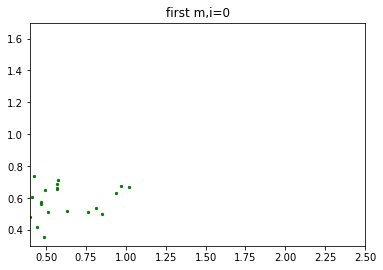

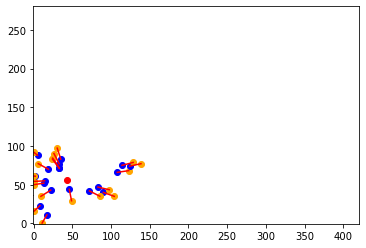

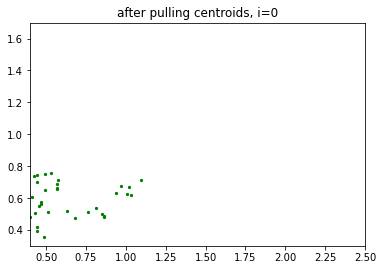

0 23.0.,1,

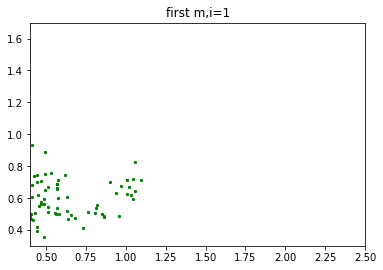

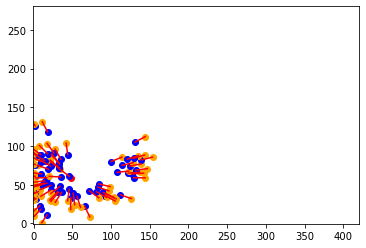

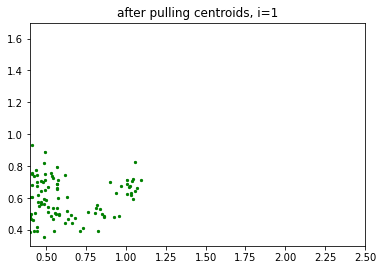

1 66.0.,2,

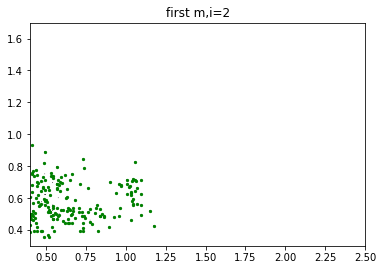

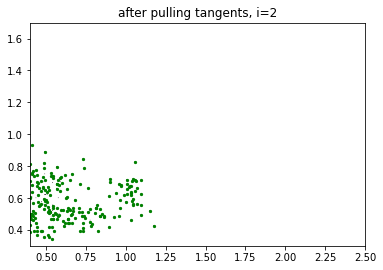

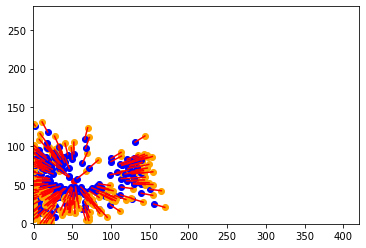

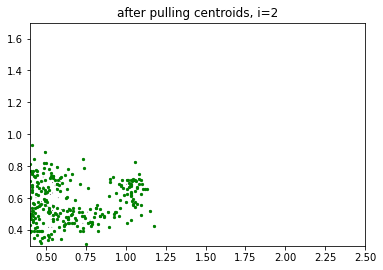

2 204.0.,3,

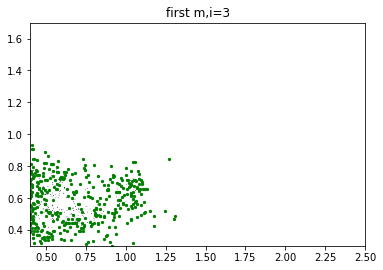

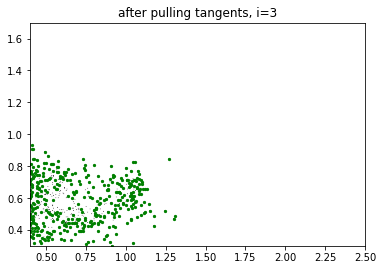

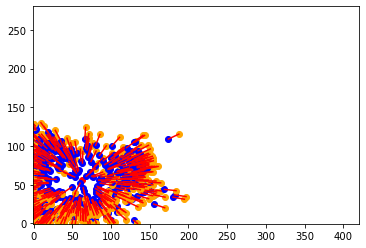

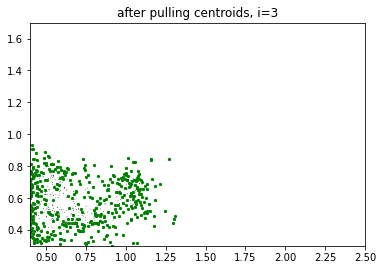

3 370.0.,4,

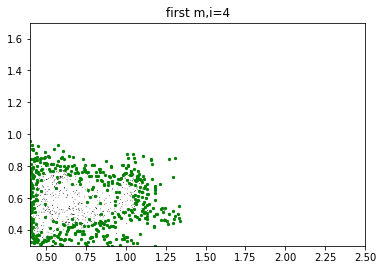

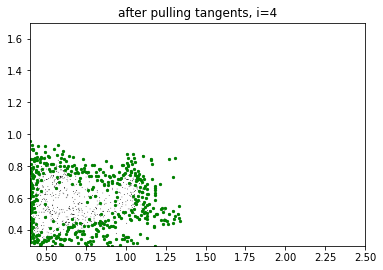

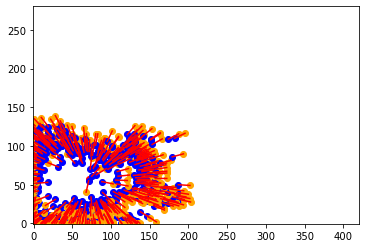

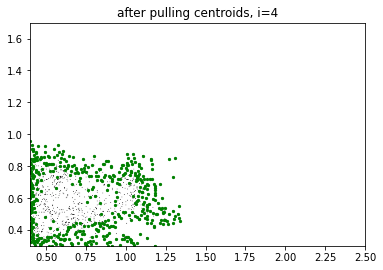

4 472.0.,5,

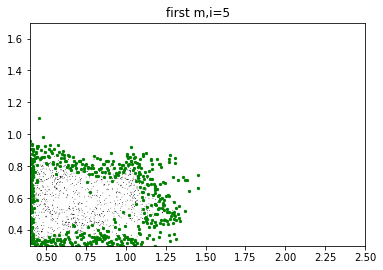

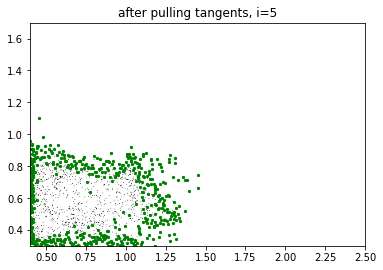

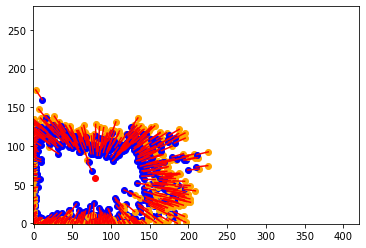

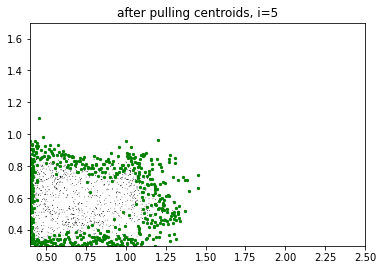

5 426.0.,6,

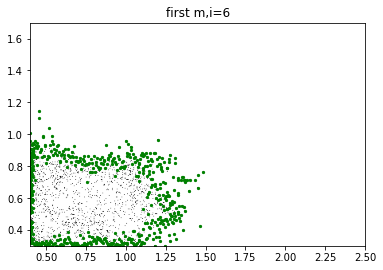

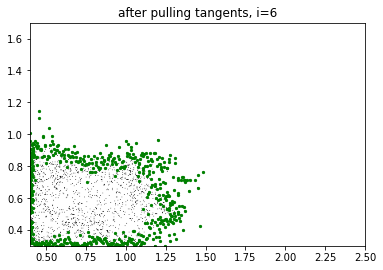

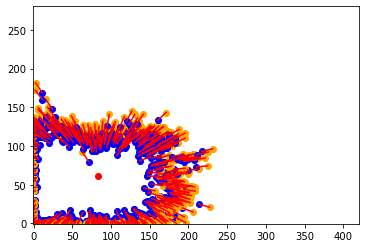

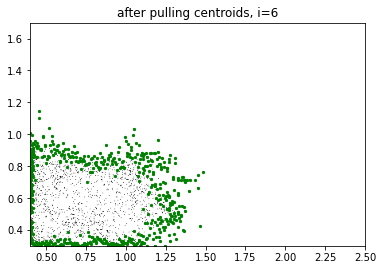

6 382.0.,7,

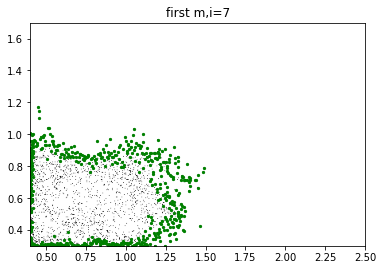

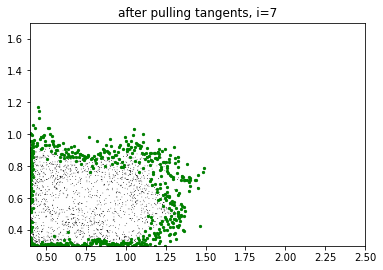

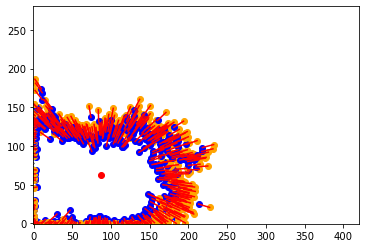

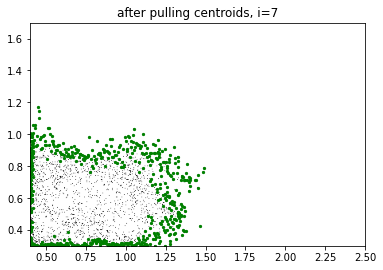

7 311.0.,8,

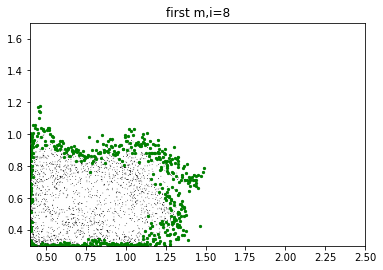

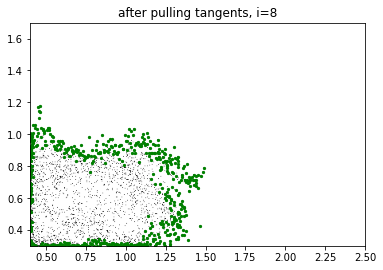

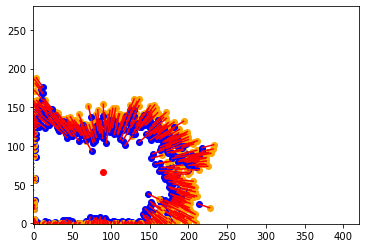

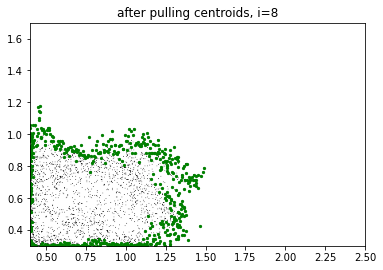

8 260.0.,9,

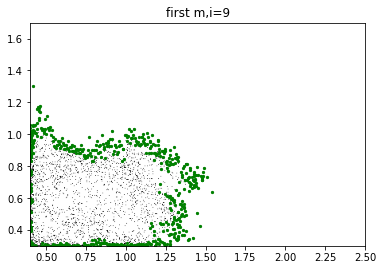

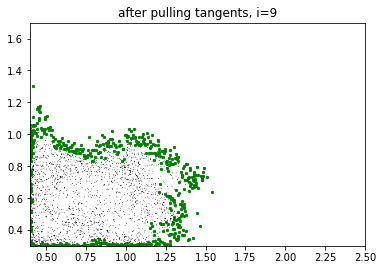

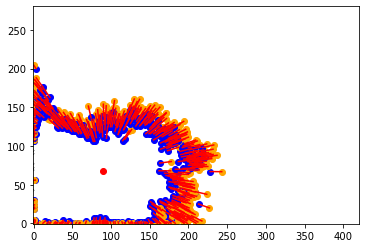

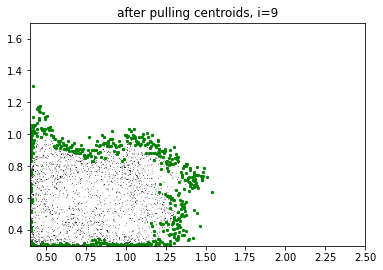

9 224.0.,10,

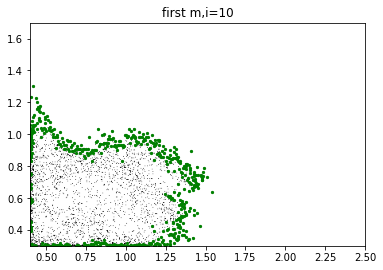

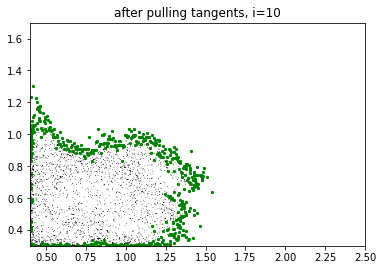

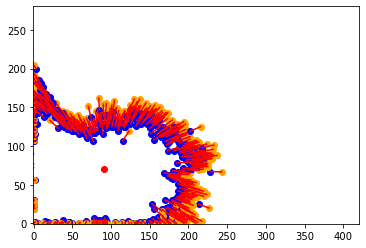

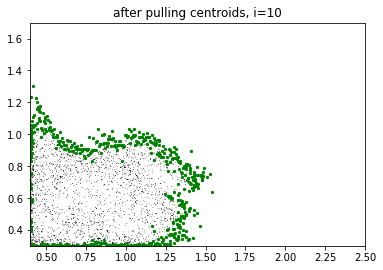

10 194.0.,11,

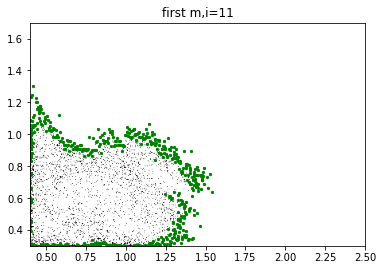

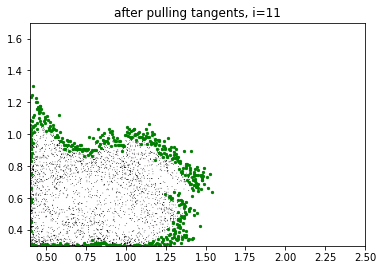

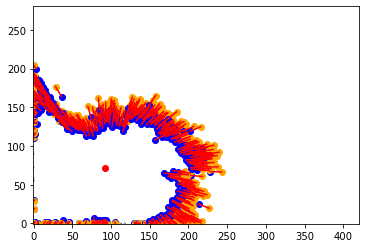

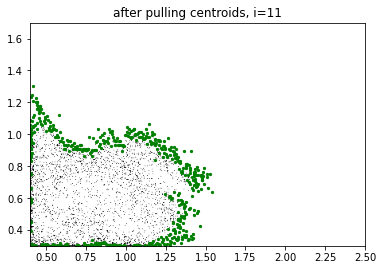

11 161.0.,12,

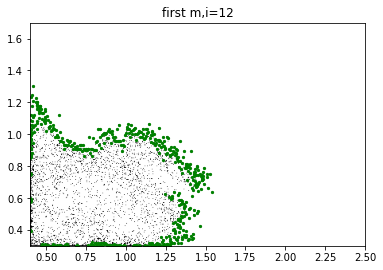

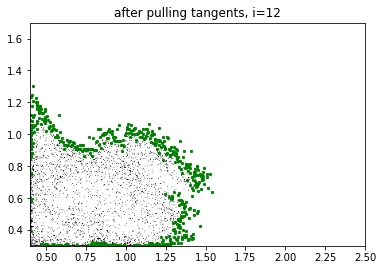

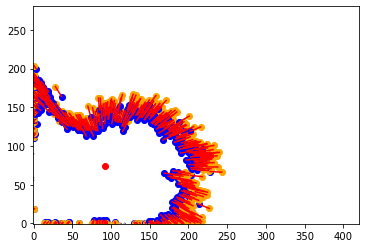

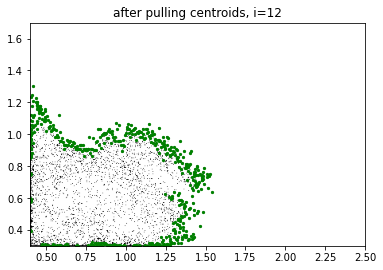

12 132.0.,13,

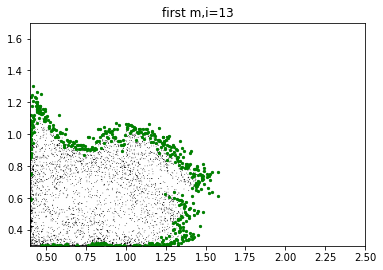

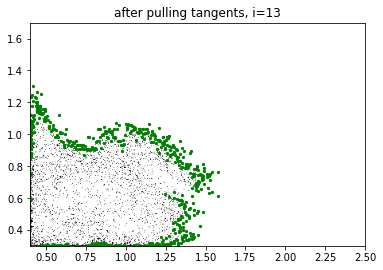

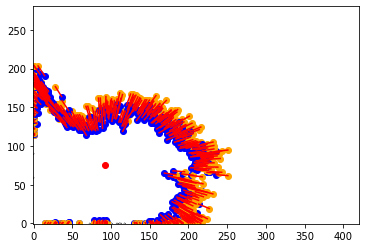

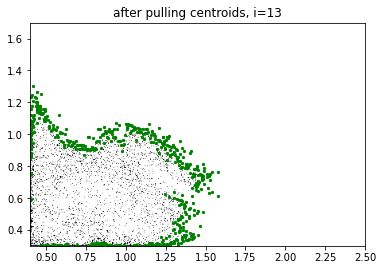

13 120.0.,14,

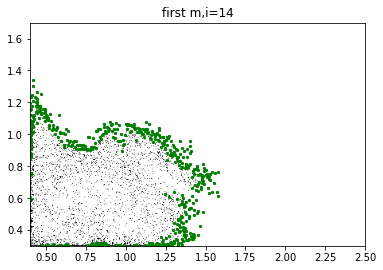

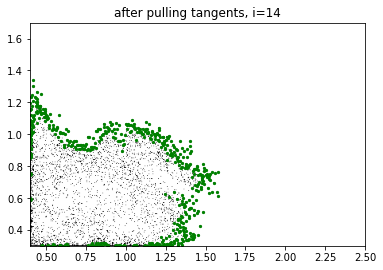

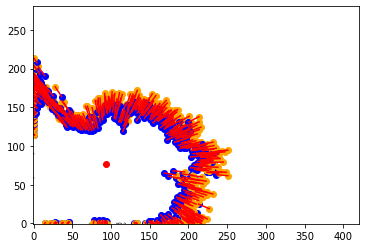

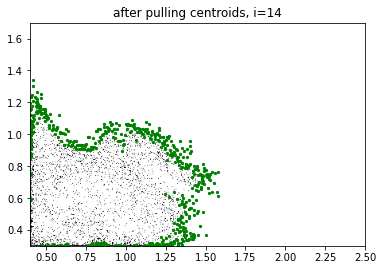

14 118.0.,15,

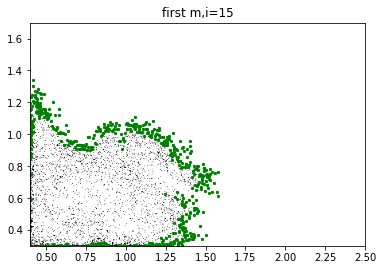

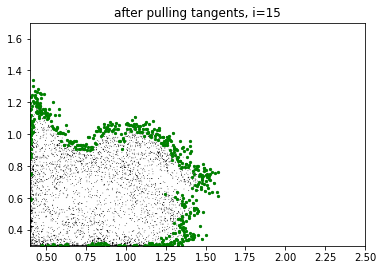

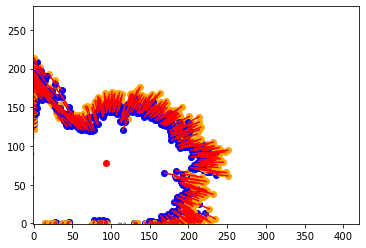

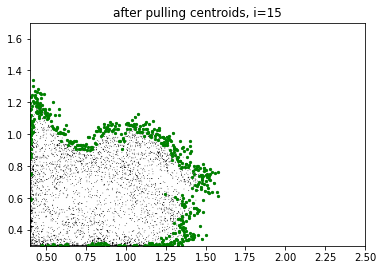

15 127.0.,16,

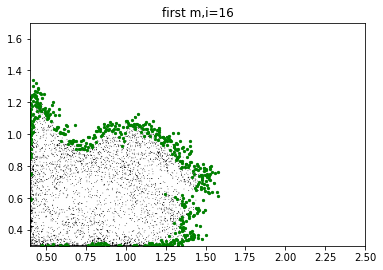

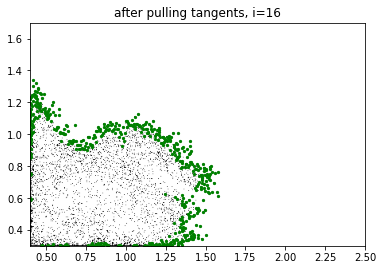

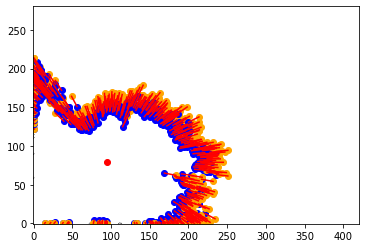

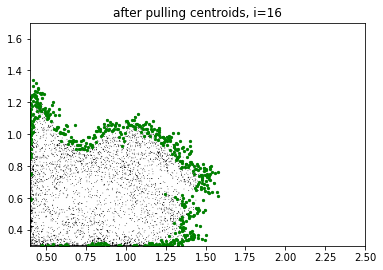

16 115.0.,17,

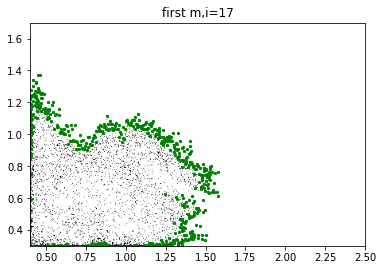

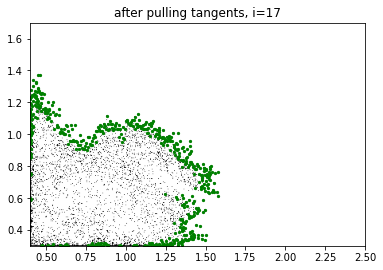

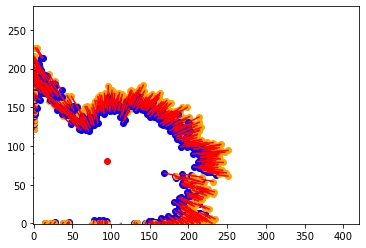

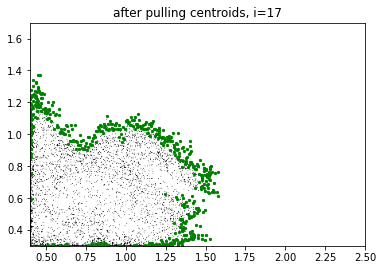

17 105.0.,18,

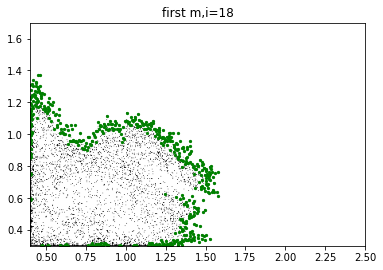

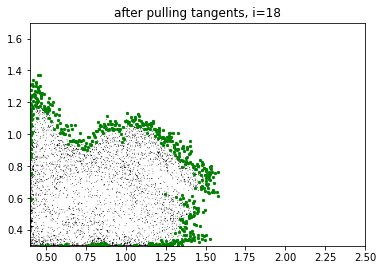

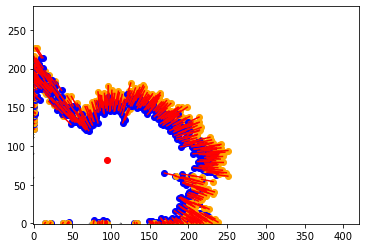

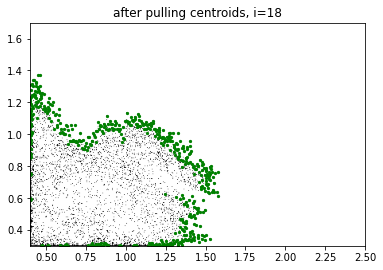

18 88.0.,19,

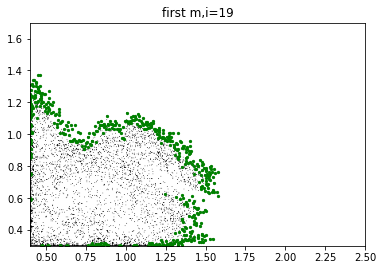

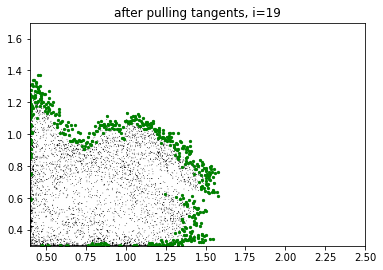

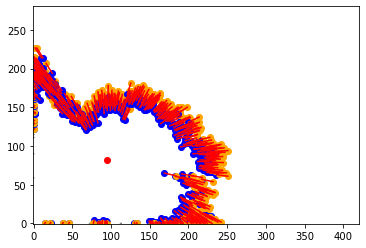

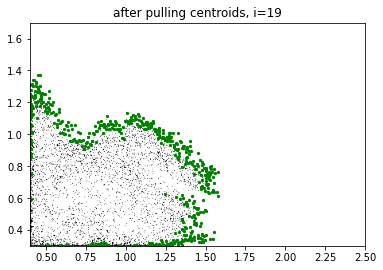

19 91.0.,20,

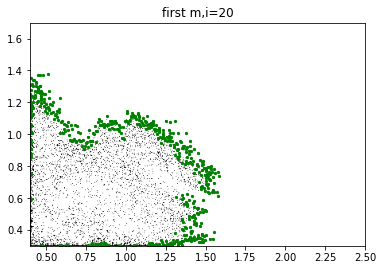

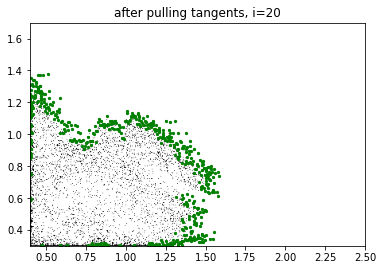

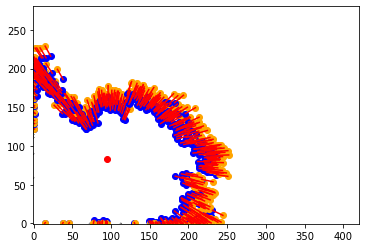

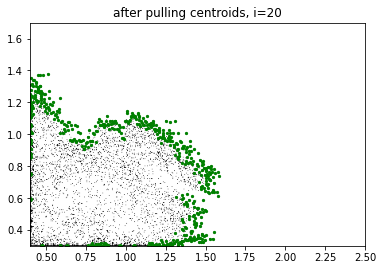

20 91.0.,21,

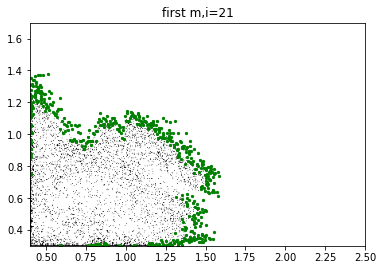

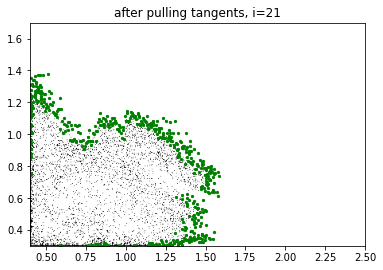

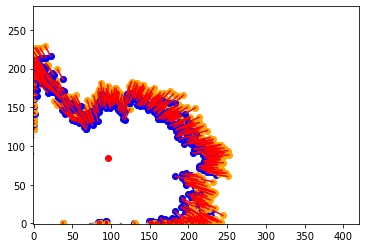

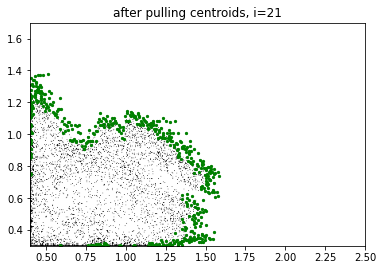

21 81.0.,22,

KeyboardInterrupt: 

In [5]:

jid=1

func_=func


func_.__name__="N4avnoneq"

#these would be the constraints for num<den
#constraints={1:{'target':0,'lt':1},3:{'target':2,'lt':1},
#                5:{'target':4,'lt':1},7:{'target':6,'lt':1},9:{'target':8,'lt':1},11:{'target':10,'lt':1},13:{'target':12,'lt':1}}
settings={'pars_limit':[minp,maxp],
          'compute_x_y_f':func_,
          'npars':64,
          'constraints':None,
           'row_ar':stp_ar,
          'col_ar':pos_ar,
          'seed':jid,
         'mat':None,
         'mat_pars':None}


name_save='N4avnoneq_space'
print(name_save)
outfolder=name_save+"_out"
if not os.path.isdir(outfolder):
    os.mkdir(outfolder)

args={'niters':niters,
      'niters_conv':niters_conv,
      'niters_conv_points':1000,
      'niters_save':3,
      'folder_save':outfolder,
       'name_save':name_save, 
      'prob_par':prob_par,
      'prob_replace':prob_replace,
      'extr_uniform':extr_uniform,
      'L_project':L,
      'plotting':True,
      'verbose':True,
       'dofirstmutate':True,'dopullcentroids':True,'dopulltangents':True}


BE=BF.BoundaryExplorer(**settings)
if settings['mat'] is None:
    BE.get_initial_points(10)
BE.extend_boundary(**args)

outfolder_final=os.path.join(outfolder,"final_results")
if not os.path.isdir(outfolder_final):
    os.mkdir(outfolder_final)
name='%s_%d_last'%(name_save,jid)
np.save(os.path.join(outfolder_final,'mat_'+name+'.npy'),BE.mat)
np.save(os.path.join(outfolder_final,'mat_pars_'+name+'.npy'),BE.mat_pars)


In [5]:
#save settings 
outfnames=[os.path.join(outfolder,name_save+'_%d.sett'%jid),os.path.join(outfolder_final,name_save+'_%d.sett'%jid)]
for fname in outfnames:
    outf=open(fname,'w')
    #outf.write(time.ctime()+'\n')
    #with open(outf, 'w') as file:
    json.dump(dict({'time':time.ctime()},**settings),outf,default=function_tostring) # use `json.loads` to do the reverse
    outf.close()

    outf=open(fname.replace('.sett','.args'),'w')
    #outf.write(time.ctime()+'\n')
    #with open(outf, 'w') as file:
    json.dump(dict({'time':time.ctime()},**args),outf) # use `json.loads` to do the reverse
    outf.close()

In [5]:
name_ashape="ashape_N4univ" 
date="2022_1_2"  #substitute by the new one with all region covered
plim=3
foldernew="./ashapes"   
ashape=np.load(os.path.join(foldernew,"%s_%d_%s.npy"%(name_ashape,plim,date)))


In [6]:
mat=np.load("N4avnoneq_space_out/mat_N4avnoneq_space_21.npy")
mat_pars=np.load("N4avnoneq_space_out/mat_pars_N4avnoneq_space_21.npy")


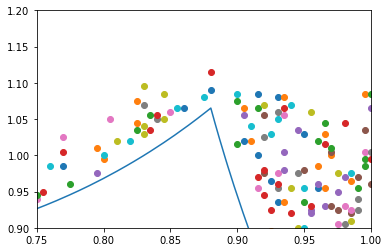

In [7]:
plt.plot(ashape[0],ashape[1])

for i in range(len(mat)):
    for j in range(len(mat[0])):
        if mat[i,j]>0:
            stp=stp_ar[i]
            pos=pos_ar[j]
            if pos>0.5 and stp>0.8:
                idxs_x=np.where(((np.abs(ashape[0]-pos)<0.01)))[0]
                outside=True
                for idx in idxs_x:
                    stp_ashape=ashape[1][idx]
                    if stp_ashape>stp:
                        outside=False
                if outside:    
                    plt.scatter(pos,stp)
            
plt.xlim(0.75,1)
plt.ylim(0.9,1.2)
plt.show()

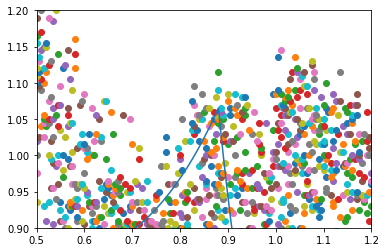

In [10]:
plt.plot(ashape[0],ashape[1])

for i in range(len(mat)):
    for j in range(len(mat[0])):
        if mat[i,j]>0:
            stp=stp_ar[i]
            pos=pos_ar[j]
            if pos>0.5 and stp>0.8:
                
                plt.scatter(pos,stp)
            
plt.xlim(0.5,1.2)
plt.ylim(0.9,1.2)
plt.show()

0.5850000000000002 0.8000000000000005 [0.6513004498478652, 0.7639566399168838, 0.3981621803925181]
0.6150000000000002 0.8000000000000005 [0.6991726935839041, 0.8567652903960539, 0.3529838010907381]
0.6400000000000002 0.8000000000000005 [0.7469427714567304, 0.8561718871684764, 1.5959537517857167]
0.6600000000000003 0.8000000000000005 [0.7128288994718621, 0.8456123408519224, 0.6876757952823203]
0.7850000000000004 0.8000000000000005 [0.7326330201530269, 0.8409751696126692, 0.0041206098481353145]
0.8700000000000004 0.8000000000000005 [0.00011724839615312403, 26.473033121215398, 40.10147214058653]
0.9050000000000005 0.8000000000000005 [0.8267833825107582, 0.8807719690487161, 0.20315652849980942]
0.9950000000000006 0.8000000000000005 [0.7314529884889306, 0.8643192881776891, 41.63532376713734]
1.0150000000000006 0.8000000000000005 [0.7852166481863483, 0.8904276162253688, 0.01694427152812689]
1.0800000000000005 0.8000000000000005 [0.0001808946582811854, 1.4966263887248215, 1.2508629265827131]


0.7600000000000003 0.8150000000000004 [0.8044342425811857, 0.9490015622043027, 0.019486281535618818]
0.7850000000000004 0.8150000000000004 [0.7469427714567303, 0.8632882966720463, 0.004416360393858097]
0.8100000000000004 0.8150000000000004 [0.7764062252205537, 0.9053871576880749, 0.609226067837]
0.9150000000000005 0.8150000000000004 [0.770173655089086, 0.9027274313877909, 1.1652165398584342]
0.9400000000000005 0.8150000000000004 [0.9122124801314099, 0.9152869587963167, 4.885048579038726]
0.9550000000000005 0.8150000000000004 [0.00038713174565163563, 3.157056988420868, 4.844718267983372]
0.9650000000000005 0.8150000000000004 [0.8031385626816754, 0.9577119267117036, 0.46298461182685946]
0.9900000000000005 0.8150000000000004 [0.7764062252205528, 0.9020672192884722, 0.11125118112332766]
1.0400000000000005 0.8150000000000004 [0.8593961808323678, 0.8904278388052251, 44.56202279847363]
1.0800000000000005 0.8150000000000004 [0.8415743866693577, 0.907989869763854, 6.161393809520706]
1.215000000

0.9200000000000005 0.8300000000000005 [0.8832722970935728, 0.939050205562783, 0.6055893344398807]
0.9800000000000005 0.8300000000000005 [0.9136841257844864, 0.9829770847485734, 0.4468533483237653]
0.9850000000000005 0.8300000000000005 [0.00030892210459651054, 1.0962155323004639, 4.3527515254158144]
1.0300000000000007 0.8300000000000005 [0.790295991208745, 0.8982971849343296, 14.696594842967794]
1.0550000000000006 0.8300000000000005 [0.7529873474773922, 0.9263002348438527, 0.5956312810798527]
1.1650000000000007 0.8300000000000005 [0.8031385626816763, 0.9212294502269818, 2.570638479249836]
1.2500000000000009 0.8300000000000005 [0.9405834648757773, 1.0014645440714163, 4.40620203214847]
1.2550000000000008 0.8300000000000005 [0.9792624233613086, 0.9393512637961089, 4.901951803445339]
1.2800000000000007 0.8300000000000005 [0.8348186817105621, 0.9552102773873156, 0.20750649901086649]
1.2850000000000008 0.8300000000000005 [1.0, 1.0949216324182685, 0.8633633710023368]
1.330000000000001 0.830000

0.5950000000000002 0.8500000000000005 [0.8832722970935728, 0.9189197750697697, 19.553707884470082]
0.6150000000000002 0.8500000000000005 [0.7639911166667688, 0.9950028138728675, 22.56500029502623]
0.6550000000000002 0.8500000000000005 [0.7652236411392147, 0.9984196986098868, 0.6921241742876638]
0.7100000000000003 0.8500000000000005 [0.9745382282796561, 1.0785659902156246, 12.187330562537475]
0.7450000000000003 0.8500000000000005 [0.817506565319177, 1.0703897170180734, 1.418780436974181]
0.7900000000000004 0.8500000000000005 [0.8175065653191771, 1.0031164153587435, 7.8956836407477615]
0.8150000000000004 0.8500000000000005 [0.995175761911259, 0.9737017272595382, 0.6014200712968311]
0.8200000000000004 0.8500000000000005 [0.775155689270411, 0.9608138276550205, 0.00764343063805364]
0.8450000000000004 0.8500000000000005 [0.881849634928588, 0.9501367862989445, 0.2582505196757887]
0.8700000000000004 0.8500000000000005 [0.0005132997315193045, 2.218608543286875, 5.409701691144315]
0.885000000000

1.270000000000001 0.8650000000000004 [0.948195063079119, 1.0031559699545314, 4.767248895307453]
1.2800000000000007 0.8650000000000004 [1.001613270685427, 1.0061608389805252, 2.168870508216332]
1.290000000000001 0.8650000000000004 [0.9375559616551985, 1.041124122720041, 0.43970794860020507]
1.3350000000000009 0.8650000000000004 [0.9421008806068587, 1.1517114352967068, 4.150131006021812]
0.5400000000000001 0.8700000000000006 [0.6693951605393664, 0.8510947710648991, 0.1177625227523094]
0.5450000000000002 0.8700000000000006 [0.415395556139521, 0.7367044886975241, 0.17144444275382392]
0.5650000000000002 0.8700000000000006 [0.7290986240321352, 0.7914287524341108, 0.14269719673354647]
0.5950000000000002 0.8700000000000006 [0.6275954234668217, 0.8078989083237367, 21.312424767462677]
0.6100000000000002 0.8700000000000006 [0.8861245105437201, 1.0800408774363974, 0.11125118112332777]
0.6350000000000002 0.8700000000000006 [0.8875540692402185, 0.9315909742254406, 0.138201911979294]
0.64000000000000

1.3150000000000008 0.8800000000000006 [0.949724758378451, 1.0899744932192177, 0.19594275630192629]
1.4000000000000008 0.8800000000000006 [0.8961799834194443, 1.1279652122553296, 1.9148211368645356]
1.450000000000001 0.8800000000000006 [1.0580408853377958, 1.4215103864575533, 9.47758459994599]
0.5550000000000002 0.8850000000000005 [0.48884245545337196, 0.7738987109013918, 0.17584276838176893]
0.6650000000000003 0.8850000000000005 [0.6037791168208401, 0.744638609553851, 0.14135625524914994]
0.7100000000000003 0.8850000000000005 [0.9682747345950934, 1.19615111961922, 6.9628057361050395]
0.7550000000000003 0.8850000000000005 [0.7481477923336132, 0.9252409664356194, 0.12630197479287245]
0.7750000000000004 0.8850000000000005 [0.8663507772826117, 1.1372443232486076, 46.73766019198554]
0.7950000000000004 0.8850000000000005 [0.9792624233613074, 1.094287618562173, 2.8783653276738863]
0.8250000000000004 0.8850000000000005 [0.9903747970956538, 0.9965162630883654, 5.832793317400663]
0.8300000000000

0.8150000000000004 0.9000000000000006 [0.7992640310370498, 1.0529347213726448, 0.03691107685938272]
0.8600000000000004 0.9000000000000006 [0.88612451054372, 1.0273708927155827, 5.4736097114773985]
0.8700000000000004 0.9000000000000006 [0.9967812497947968, 1.168302550467757, 16.827616358112678]
0.9450000000000005 0.9000000000000006 [0.9151581456003544, 1.0814796810637537, 4.659795275141307]
0.9500000000000005 0.9000000000000006 [1.0277824323562608, 1.0687579736934947, 4.551618108478589]
1.0100000000000007 0.9000000000000006 [0.8889859342018551, 1.032541031075804, 5.254991975731612]
1.0250000000000006 0.9000000000000006 [0.9558682575462413, 1.021595922034993, 5.2889850232381]
1.0350000000000006 0.9000000000000006 [0.00010643947168939471, 3.9552860850192793, 2.3929735251520343]
1.0500000000000007 0.9000000000000006 [0.9005243271784573, 1.0121403403212612, 39.06242275818957]
1.0550000000000006 0.9000000000000006 [0.8267833825107573, 1.0170468042357106, 2.5161705446290346]
1.280000000000000

1.3600000000000008 0.9150000000000005 [1.024474257441211, 1.3737204448407394, 3.876670111132539]
0.6150000000000002 0.9200000000000006 [0.00032632576525671865, 5.530456126155694, 19.18351971853117]
0.6500000000000002 0.9200000000000006 [0.6255753505687532, 0.8390262592189283, 0.13455904348909678]
0.6550000000000002 0.9200000000000006 [0.5697384996315844, 0.7866024082984591, 0.14142137371515334]
0.6800000000000003 0.9200000000000006 [0.8307913176290604, 0.9573047097628112, 0.11877019533873631]
0.7650000000000003 0.9200000000000006 [0.9151581456003544, 1.2247676557354648, 1.3474509076973773]
0.7800000000000004 0.9200000000000006 [0.7326330201530278, 0.8828442158084527, 0.13289613519442203]
0.7850000000000004 0.9200000000000006 [0.7739071675238038, 0.9583510814243177, 0.12960186796964573]
0.8000000000000004 0.9200000000000006 [0.8135627190089684, 1.0546263239363847, 0.13335598183864825]
0.8650000000000004 0.9200000000000006 [0.8375144314586785, 1.0447101693690815, 0.2348210759770192]
0.91

0.5250000000000001 0.9350000000000005 [0.00027864066918175344, 20.915739332761188, 21.400949554290776]
0.5500000000000002 0.9350000000000005 [0.7664581540072594, 0.90673173863071, 19.082183278870843]
0.5700000000000002 0.9350000000000005 [0.6846735462670284, 0.8666950900190002, 0.19374420566740863]
0.6100000000000002 0.9350000000000005 [0.5874581018442159, 0.8050047290322891, 23.28288020710736]
0.6200000000000002 0.9350000000000005 [0.0007436817751915261, 7.390840518193681, 19.68472776321527]
0.6250000000000002 0.9350000000000005 [0.00027864066918175344, 8.448921855539195, 19.312059146565893]
0.6600000000000003 0.9350000000000005 [0.7349987976838961, 0.9017757903180311, 19.329856184652893]
0.7000000000000003 0.9350000000000005 [0.7689331577666083, 0.9135057867351913, 18.746806327404943]
0.7100000000000003 0.9350000000000005 [0.8135627190089684, 1.037833509403823, 0.11593282552104722]
0.7200000000000003 0.9350000000000005 [0.7979766786537235, 0.9318874872129475, 0.1398667783087448]
0.73

0.9750000000000005 0.9500000000000006 [1.008092421871723, 1.1622118491077102, 2.0827246790225815]
1.0450000000000006 0.9500000000000006 [0.9315301581778759, 1.1149765651761694, 1.0869351171879134]
1.0750000000000006 0.9500000000000006 [0.9375559616551985, 1.161232205537713, 0.01329879774941522]
1.0800000000000005 0.9500000000000006 [0.8918565978090649, 1.1370398864910405, 0.03323932265422795]
1.1050000000000006 0.9500000000000006 [1.0211767307148474, 1.1148564257453188, 5.413440245643496]
1.1500000000000008 0.9500000000000006 [0.9300297684159161, 1.1563968434122343, 4.591622724771664]
1.1600000000000006 0.9500000000000006 [0.7689331577666075, 1.111181714154335, 2.4759357687647254]
1.1700000000000008 0.9500000000000006 [0.9122124801314099, 1.1295256078204874, 4.874934634928898]
1.1950000000000007 0.9500000000000006 [0.8775953823312233, 1.2548652042437085, 14.578618511664494]
1.2400000000000007 0.9500000000000006 [0.8889859342018551, 1.132151867344129, 4.568419499727579]
1.24500000000000

1.2000000000000006 0.9650000000000005 [1.0178898179033105, 1.1437856976971996, 1.0209415996414932]
1.2100000000000009 0.9650000000000005 [0.952791556396116, 1.1684028012935372, 14.508287784959299]
1.2450000000000008 0.9650000000000005 [1.0048476241819597, 1.20481423937307, 4.46339134035375]
1.2500000000000009 0.9650000000000005 [0.9270362349079831, 1.1993229860861714, 4.616006658852572]
1.2750000000000008 0.9650000000000005 [0.8388655689395728, 1.1726213810878543, 2.1539386206191113]
1.2800000000000007 0.9650000000000005 [0.9225639913938961, 1.2291730315598643, 0.1949076938320454]
0.5550000000000002 0.9700000000000006 [0.4657649639639178, 0.7576195785475652, 0.1705780684399427]
0.6750000000000003 0.9700000000000006 [0.6924430145429809, 0.8722074662066622, 0.12706045349077782]
0.8450000000000004 0.9700000000000006 [0.8649553701397626, 1.1669215320141666, 0.25225523278909745]
0.8850000000000005 0.9700000000000006 [0.9300297684159161, 1.1502104516481275, 0.21995519987642723]
0.90000000000

1.0400000000000005 0.9900000000000007 [0.9682747345950934, 1.2354576213955877, 2.56472558420323]
1.0500000000000007 0.9900000000000007 [1.0129792750736384, 1.1916693963280254, 0.2417900047755812]
1.0600000000000005 0.9900000000000007 [0.8947365312024748, 1.30546967336441, 2.7048501770033235]
1.1150000000000007 0.9900000000000007 [0.9451430600252614, 1.212424589478395, 2.1678718365393066]
1.1250000000000007 0.9900000000000007 [1.0016132706854268, 1.1904779379265924, 5.206809123579767]
1.1450000000000007 0.9900000000000007 [0.8538727212132586, 1.1927431645041056, 5.621794774543826]
1.1500000000000008 0.9900000000000007 [0.8538727212132587, 1.2346516240873655, 4.547427424385534]
1.1800000000000006 0.9900000000000007 [0.8018449696978058, 1.1702976773386464, 0.02921100873916472]
1.270000000000001 0.9900000000000007 [0.9181133230473109, 1.2169060516284076, 0.21282997953846008]
0.5300000000000001 0.9950000000000006 [0.41808263176952154, 0.8376326740760883, 0.1249135816195121]
0.56500000000000

1.0050000000000006 1.0150000000000006 [1.01461348484306, 1.2241873716931273, 5.302399517802393]
1.0250000000000006 1.0150000000000006 [0.8904201091492588, 1.2073901799223001, 2.4084529898396942]
1.0400000000000005 1.0150000000000006 [1.001613270685426, 1.2895383541213723, 2.527785824372267]
1.0700000000000007 1.0150000000000006 [0.9636035467400942, 1.2381420944441968, 4.981610142969896]
1.0850000000000006 1.0150000000000006 [1.0064687153973741, 1.2308570876679104, 0.22910575766691757]
1.0950000000000006 1.0150000000000006 [1.0495475041597215, 1.21085196782329, 5.1400944241443165]
1.1000000000000005 1.0150000000000006 [1.0129792750736386, 1.2317799091343336, 5.15669252928111]
1.1400000000000006 1.0150000000000006 [0.9122124801314098, 1.2706095518399059, 5.5318995751934725]
1.1650000000000007 1.0150000000000006 [0.903432249918269, 1.2325227739661442, 0.22721429101683613]
1.2050000000000007 1.0150000000000006 [0.8663507772826117, 1.245486210850817, 13.044022556850877]
0.5000000000000001 1

0.9100000000000005 1.0400000000000007 [1.0461692729153358, 1.275985418792851, 2.3732174541416615]
1.0550000000000006 1.0400000000000007 [0.9651581000944224, 1.2917390952089436, 0.22425135377832292]
1.0600000000000005 1.0400000000000007 [1.037771190634402, 1.323755816963656, 1.1727539940310916]
1.0750000000000006 1.0400000000000007 [0.9107432048171276, 1.3409345318997752, 5.559996362446077]
1.0950000000000006 1.0400000000000007 [0.8947365312024756, 1.275025509888103, 5.293859090119523]
1.1000000000000005 1.0400000000000007 [1.0129792750736384, 1.3176398573352657, 4.451074327035037]
1.1400000000000006 1.0400000000000007 [1.0097187478241296, 1.2745482131933752, 5.148386787799115]
1.2050000000000007 1.0400000000000007 [0.8148752158943008, 1.3198389523488423, 5.434674242629028]
0.5150000000000001 1.0450000000000006 [0.6116157320617769, 0.7766682828088067, 0.14057716848492774]
0.5250000000000001 1.0450000000000006 [0.5130633790483958, 0.8970689690936073, 0.17311066805879677]
0.57000000000000

0.9350000000000005 1.0650000000000006 [0.9034322499182681, 1.318446062647984, 2.20665466893271]
1.0000000000000004 1.0650000000000006 [0.972968566613297, 1.3508613721418758, 1.0225886547957277]
1.0150000000000006 1.0650000000000006 [0.8442919515616985, 1.3403772717239448, 5.320746858159972]
1.0200000000000005 1.0650000000000006 [0.9034322499182681, 1.3315920914824728, 4.711588105555609]
1.0500000000000007 1.0650000000000006 [0.9405834648757774, 1.3522161662533938, 0.4617069762364716]
1.0650000000000006 1.0650000000000006 [0.9405834648757782, 1.3375017494237549, 2.164380105562881]
1.0700000000000007 1.0650000000000006 [1.0311012898445342, 1.327878886786251, 4.999998764129932]
1.0850000000000006 1.0650000000000006 [1.0032291440131573, 1.3319138007310822, 4.991945404944888]
1.1050000000000006 1.0650000000000006 [0.9034322499182681, 1.345620154401508, 4.758474504869288]
1.1200000000000006 1.0650000000000006 [0.9151581456003545, 1.3570144576962393, 5.269533590047519]
1.1450000000000007 1.06

1.0800000000000005 1.1150000000000007 [1.0563367282601528, 1.4354861961219731, 2.249754936948186]
1.1350000000000007 1.1150000000000007 [0.9682747345950934, 1.5027539855141194, 38.856076534717516]
0.5000000000000001 1.1200000000000008 [0.2222463736833703, 2.133370154934692, 0.19621367541688112]
0.5150000000000001 1.1200000000000008 [0.5256202242708837, 0.9732736417803903, 0.1371872439592188]
0.5550000000000002 1.1200000000000008 [0.6145806152745865, 0.9094414709909898, 0.1376619386798213]
0.5800000000000002 1.1200000000000008 [0.5960429119114489, 0.9264506438957065, 0.13922408471454184]
1.0450000000000006 1.1200000000000008 [1.001613270685426, 1.5096000524734583, 38.050295669699985]
0.5250000000000001 1.1250000000000007 [0.567904653718983, 0.9896987998613436, 0.12598244452197496]
0.5600000000000002 1.1250000000000007 [0.6047531759704801, 0.9449825428292132, 0.16200221483378763]
1.0750000000000006 1.1250000000000007 [1.0097187478241285, 1.5357838148829122, 38.23474920311914]
0.505000000

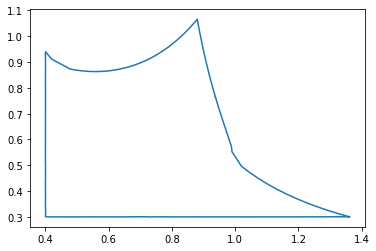

In [12]:
#reevaluate points. It seems the position tends to increase, and often the steepness as well
new=[]
plt.plot(ashape[0],ashape[1])
for i in range(len(mat)):
    for j in range(len(mat[0])):
        if mat[i,j]>0:
            stp=stp_ar[i]
            pos=pos_ar[j]
            if pos>0.5 and stp>0.8:

                pars=mat_pars[i,j]
                result=calculate_ps_fromnumerics_doublecheck_interpolate(pars,n1=100,n2=100)
                newpos=result[0]
                newstp=result[1]
                new.append([result,pars])
                print(pos,stp,result[0:3])
                #plt.scatter(newpos,newstp)
plt.show()
                

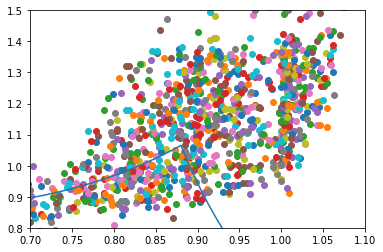

In [14]:

plt.plot(ashape[0],ashape[1])
for newpt in new:
    pos,stp=newpt[0][0:2]
    plt.scatter(pos,stp)
plt.xlim(0.7,1.1)
plt.ylim(0.8,1.5)
plt.show()


In [31]:
newpos=np.arange(0.7,1.1,0.005)
newstp=np.arange(0.8,1.2,0.005)
newmat=np.zeros((len(newstp),len(newpos)))
newmatpars=np.zeros((len(newstp),len(newpos),64))
for point in new:
    pos,stp=point[0][0:2]
    pars=point[1]
    if pos>=newpos[0] and pos<=newpos[-1] and stp>=newstp[0] and stp<=newstp[-1]:
        print(".",end=",")
        posidx=np.where(pos>=newpos)[0][-1]
        stpidx=np.where(stp>=newstp)[0][-1]
        newmat[stpidx,posidx]=1
        newmatpars[stpidx,posidx]=pars
    


.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,

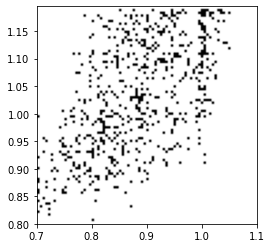

In [32]:
plt.imshow(newmat,origin="lower",extent=[newpos[0],newpos[-1],newstp[0],newstp[-1]],cmap=plt.cm.Greys)
plt.show()

In [33]:
extremesu=[-2,2]
prob_par=0.5
prob_replace=0.2
minp,maxp=[1e-3,1e3]
niters_conv=10
extr_uniform=[extremesu[0],extremesu[1]]
niters=100
L=15

In [35]:
def func2(pars,psfunc=None):
    out=[None,None]
    result=calculate_ps_fromnumerics_doublecheck_interpolate(pars,n1=50,n2=50) 
    if result[0]>0:
        out=[result[0],result[1]]
    return out

N4avnoneq_space_cont
0,

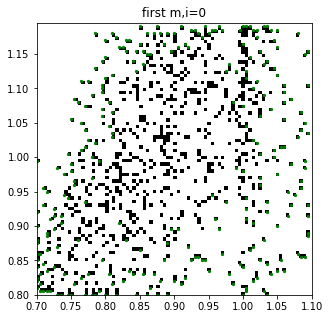

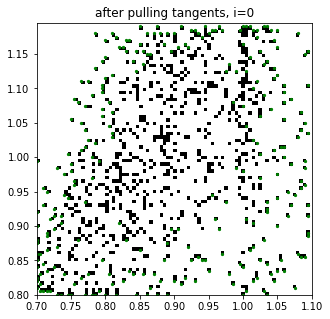

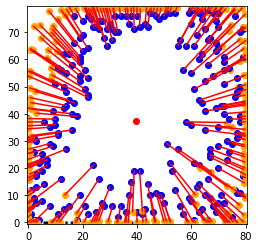

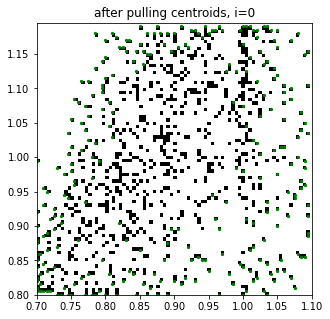

0 246.0.,1,

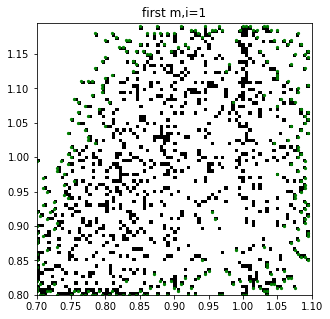

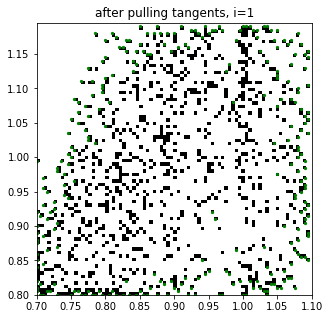

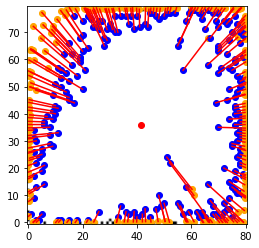

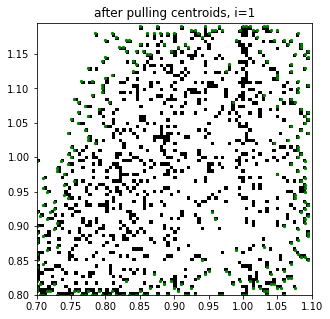

1 157.0.,2,

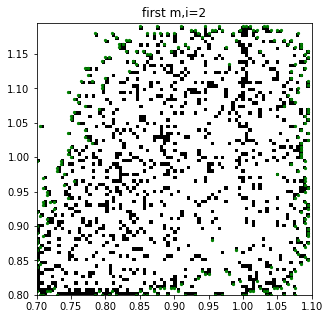

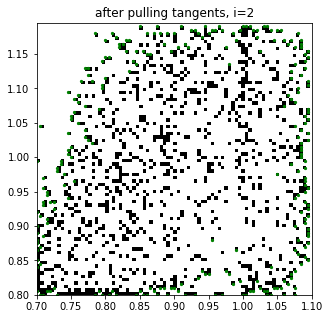

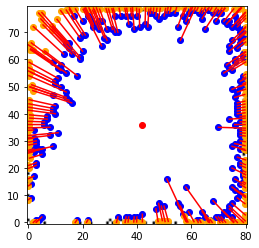

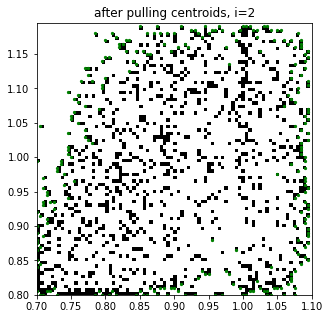

2 92.0.,3,

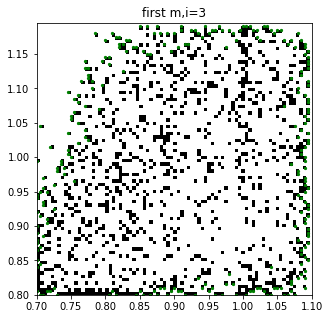

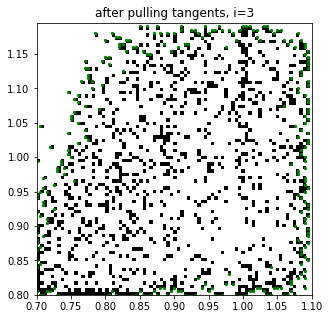

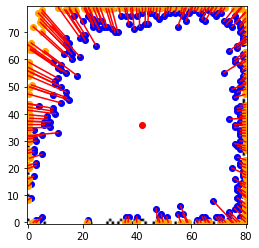

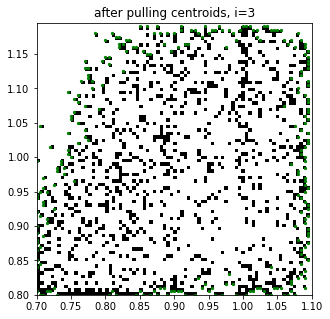

3 66.0.,4,

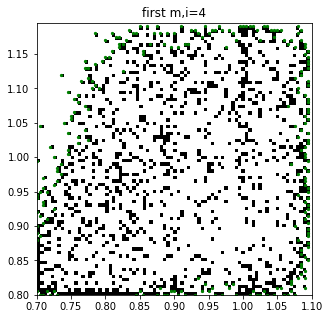

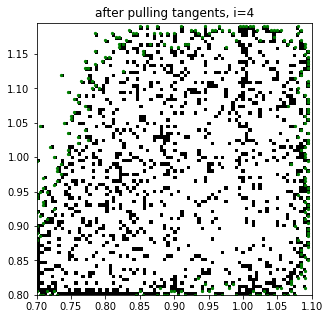

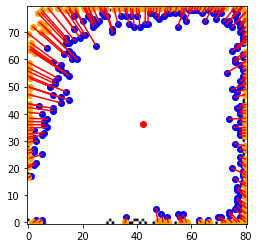

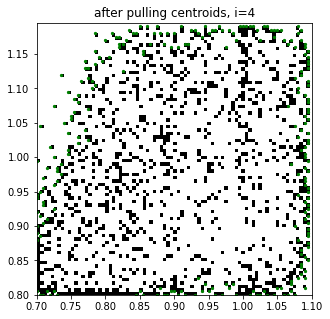

4 56.0.,5,

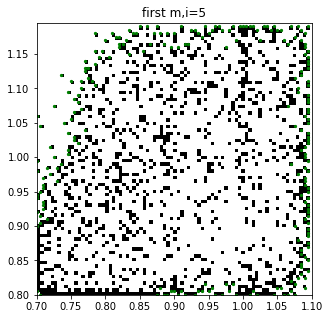

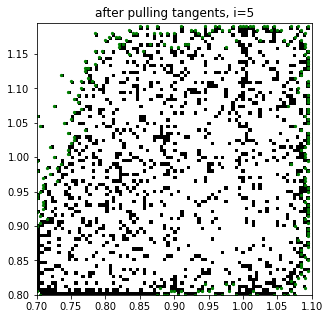

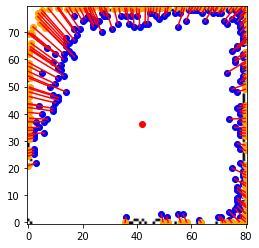

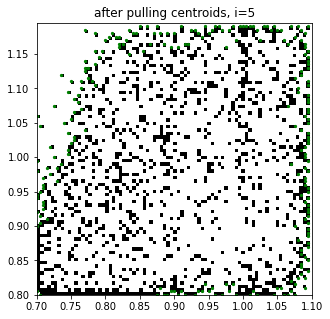

5 38.0.,6,

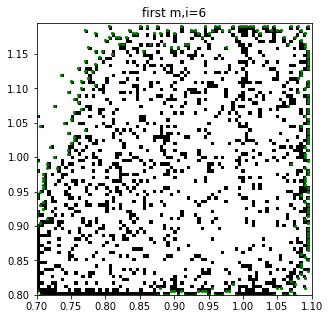

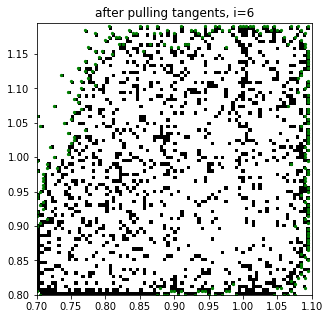

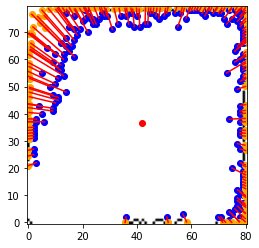

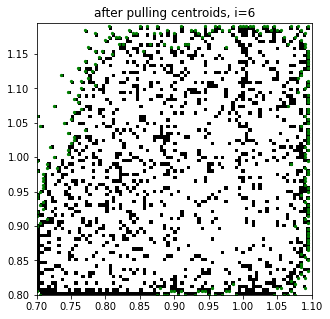

6 28.0.,7,

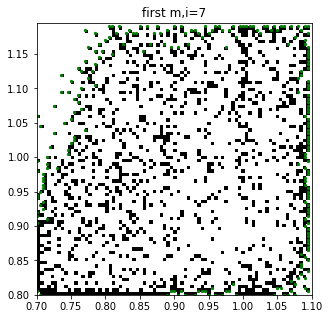

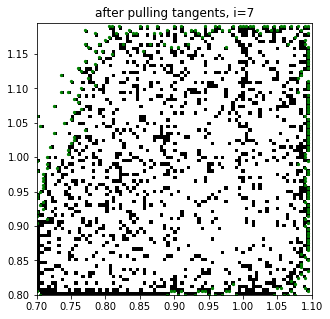

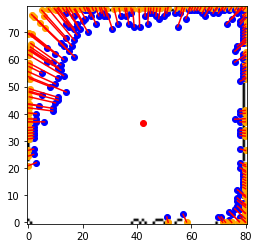

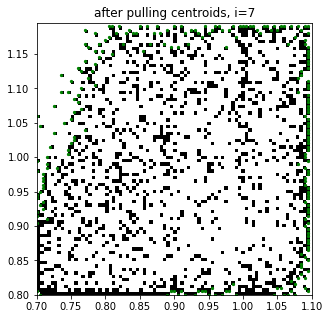

7 29.0.,8,

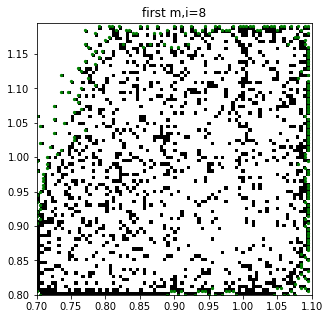

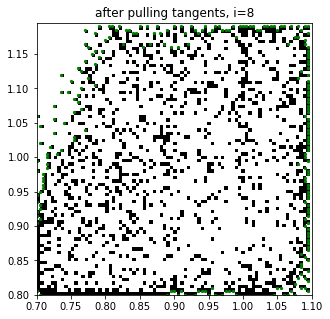

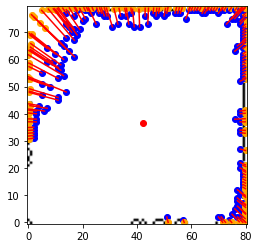

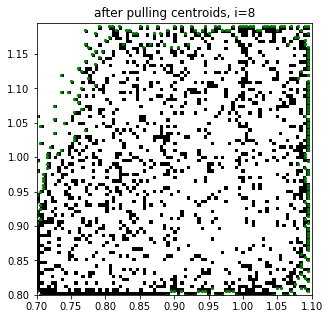

8 27.0.,9,

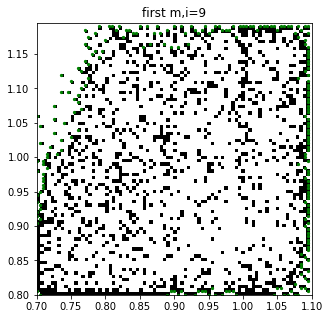

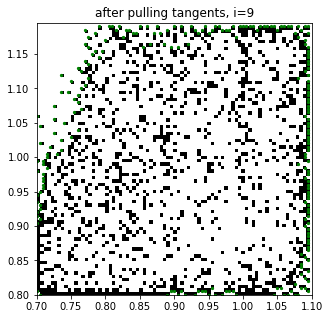

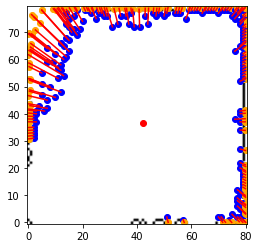

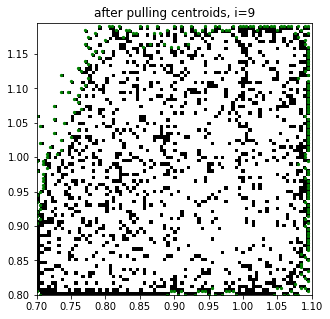

9 15.0.,10,

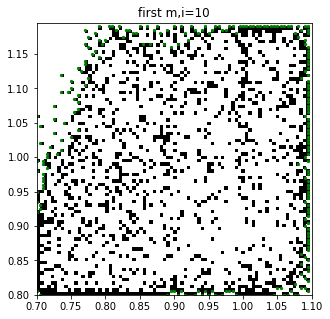

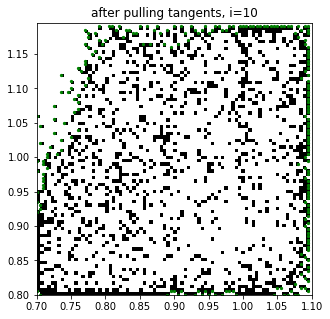

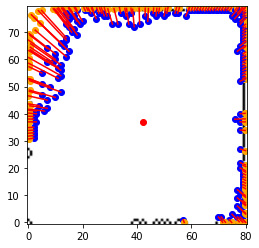

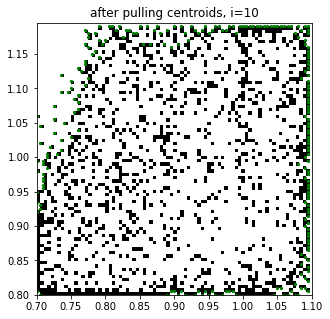

10 22.0.,11,

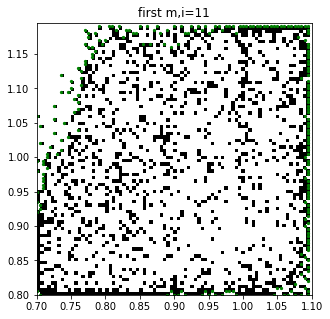

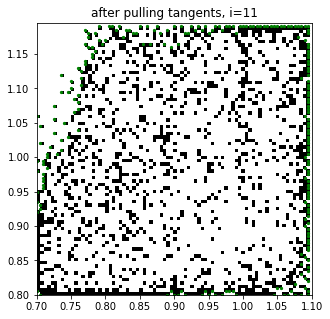

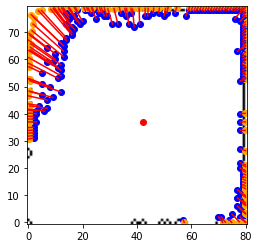

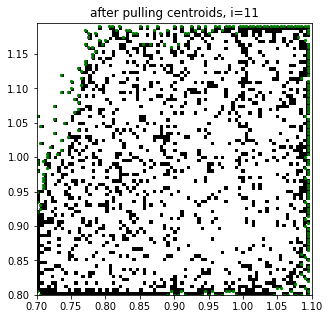

11 18.0.,12,

KeyboardInterrupt: 

In [37]:

jid=1

func_=func2


func_.__name__="N4avnoneq"

#these would be the constraints for num<den
#constraints={1:{'target':0,'lt':1},3:{'target':2,'lt':1},
#                5:{'target':4,'lt':1},7:{'target':6,'lt':1},9:{'target':8,'lt':1},11:{'target':10,'lt':1},13:{'target':12,'lt':1}}
settings={'pars_limit':[minp,maxp],
          'compute_x_y_f':func_,
          'npars':64,
          'constraints':None,
           'row_ar':newstp,
          'col_ar':newpos,
          'seed':jid,
         'mat':newmat,
         'mat_pars':newmatpars}


name_save='N4avnoneq_space_cont'
print(name_save)
outfolder=name_save+"_out"
if not os.path.isdir(outfolder):
    os.mkdir(outfolder)

args={'niters':niters,
      'niters_conv':niters_conv,
      'niters_conv_points':1000,
      'niters_save':1,
      'folder_save':outfolder,
       'name_save':name_save, 
      'prob_par':prob_par,
      'prob_replace':prob_replace,
      'extr_uniform':extr_uniform,
      'L_project':L,
      'plotting':True,
      'verbose':True,
       'dofirstmutate':True,'dopullcentroids':True,'dopulltangents':True}


BE=BF.BoundaryExplorer(**settings)
if settings['mat'] is None:
    BE.get_initial_points(10)
BE.extend_boundary(**args)

outfolder_final=os.path.join(outfolder,"final_results")
if not os.path.isdir(outfolder_final):
    os.mkdir(outfolder_final)
name='%s_%d_last'%(name_save,jid)
np.save(os.path.join(outfolder_final,'mat_'+name+'.npy'),BE.mat)
np.save(os.path.join(outfolder_final,'mat_pars_'+name+'.npy'),BE.mat_pars)


This took about 3 days to compute. Then I decided to refine the points, which I did in the cluster. The files are prepared in Fig5_C_2_pointsnoneqav4_forboundarycluster and from there I also prepared matrices to initialise new boundary runs.